In [1]:
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.io import imread as imread
from skimage.transform import resize as resize
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
image_paths = glob(
    os.path.join(
        "../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png",
        "*.png",
    )
)

In [3]:
images_with_masks_paths = [
    (
        image_path,
        os.path.join(
            "/".join(image_path.split("/")[:-2]),
            "ManualMask",
            "leftMask",
            os.path.basename(image_path),
        ),
        os.path.join(
            "/".join(image_path.split("/")[:-2]),
            "ManualMask",
            "rightMask",
            os.path.basename(image_path),
        ),
    )
    for image_path in image_paths
]

In [4]:
images_with_masks_paths[0]

('../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/MCUCXR_0047_0.png',
 '../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/leftMask/MCUCXR_0047_0.png',
 '../data/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/ManualMask/rightMask/MCUCXR_0047_0.png')

In [5]:
OUT_DIM = (512, 512)

In [6]:
def image_from_path(path):
    img = resize(imread(path), OUT_DIM, mode="constant")
    return img


def mask_from_paths(path1, path2):
    img = resize(cv2.bitwise_or(imread(path1), imread(path2)), OUT_DIM, mode="constant")
    return img

In [7]:
images, masks = [], []
for mri, left_lung, right_lung in tqdm(images_with_masks_paths, position=0, leave=True):
    images.append(image_from_path(mri))
    masks.append(mask_from_paths(left_lung, right_lung))

100%|██████████| 138/138 [05:23<00:00,  2.34s/it]


In [8]:
def random_plot(images, masks, number):
    indices = np.random.choice(len(images), number)
    fig, axis = plt.subplots(nrows=number, ncols=3, figsize=(20, 20))

    for i, index in enumerate(indices):
        img = images[index]
        mask = masks[index]

        axis[i][0].imshow(img)
        axis[i][1].imshow(mask)
        axis[i][2].imshow(cv2.addWeighted(img, 1.0, mask, 1, 1))

    plt.tight_layout()

In [9]:
import albumentations as A

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(rotate_limit=15, always_apply=True),
    ]
)

In [10]:
transformed_images, transformed_masks = [], []

for image, mask in zip(images, masks):
    sample = {"image": image.copy(), "mask": mask.copy()}
    out = transform(**sample)
    transformed_images.append(out["image"])
    transformed_masks.append(out["mask"])

In [12]:
# m, s = np.mean(transformed_images, axis=(0, 1)), np.std(transformed_images, axis=(0, 1))

In [13]:
from sklearn.model_selection import train_test_split

image_dataset = images.copy() + transformed_images
mask_dataset = masks.copy() + transformed_masks

X_train, X_val, y_train, y_val = train_test_split(
    image_dataset, mask_dataset, test_size=0.2
)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(X_train).reshape(-1, 512 * 512)).reshape(
    -1, 512, 512
)
X_val = scaler.transform(np.array(X_val).reshape(-1, 512 * 512)).reshape(-1, 512, 512)

In [15]:
X_train.mean(), X_train.std()

(-4.1191797447740184e-17, 0.9999999999999982)

In [16]:
batch_size = 32

In [17]:
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

/tmp/ipykernel_1376/3052325062.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))


In [18]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [19]:
data = next(iter(train_loader))
loader_images, loader_masks = data
loader_images.shape, loader_masks.shape

(torch.Size([32, 512, 512]), torch.Size([32, 512, 512]))

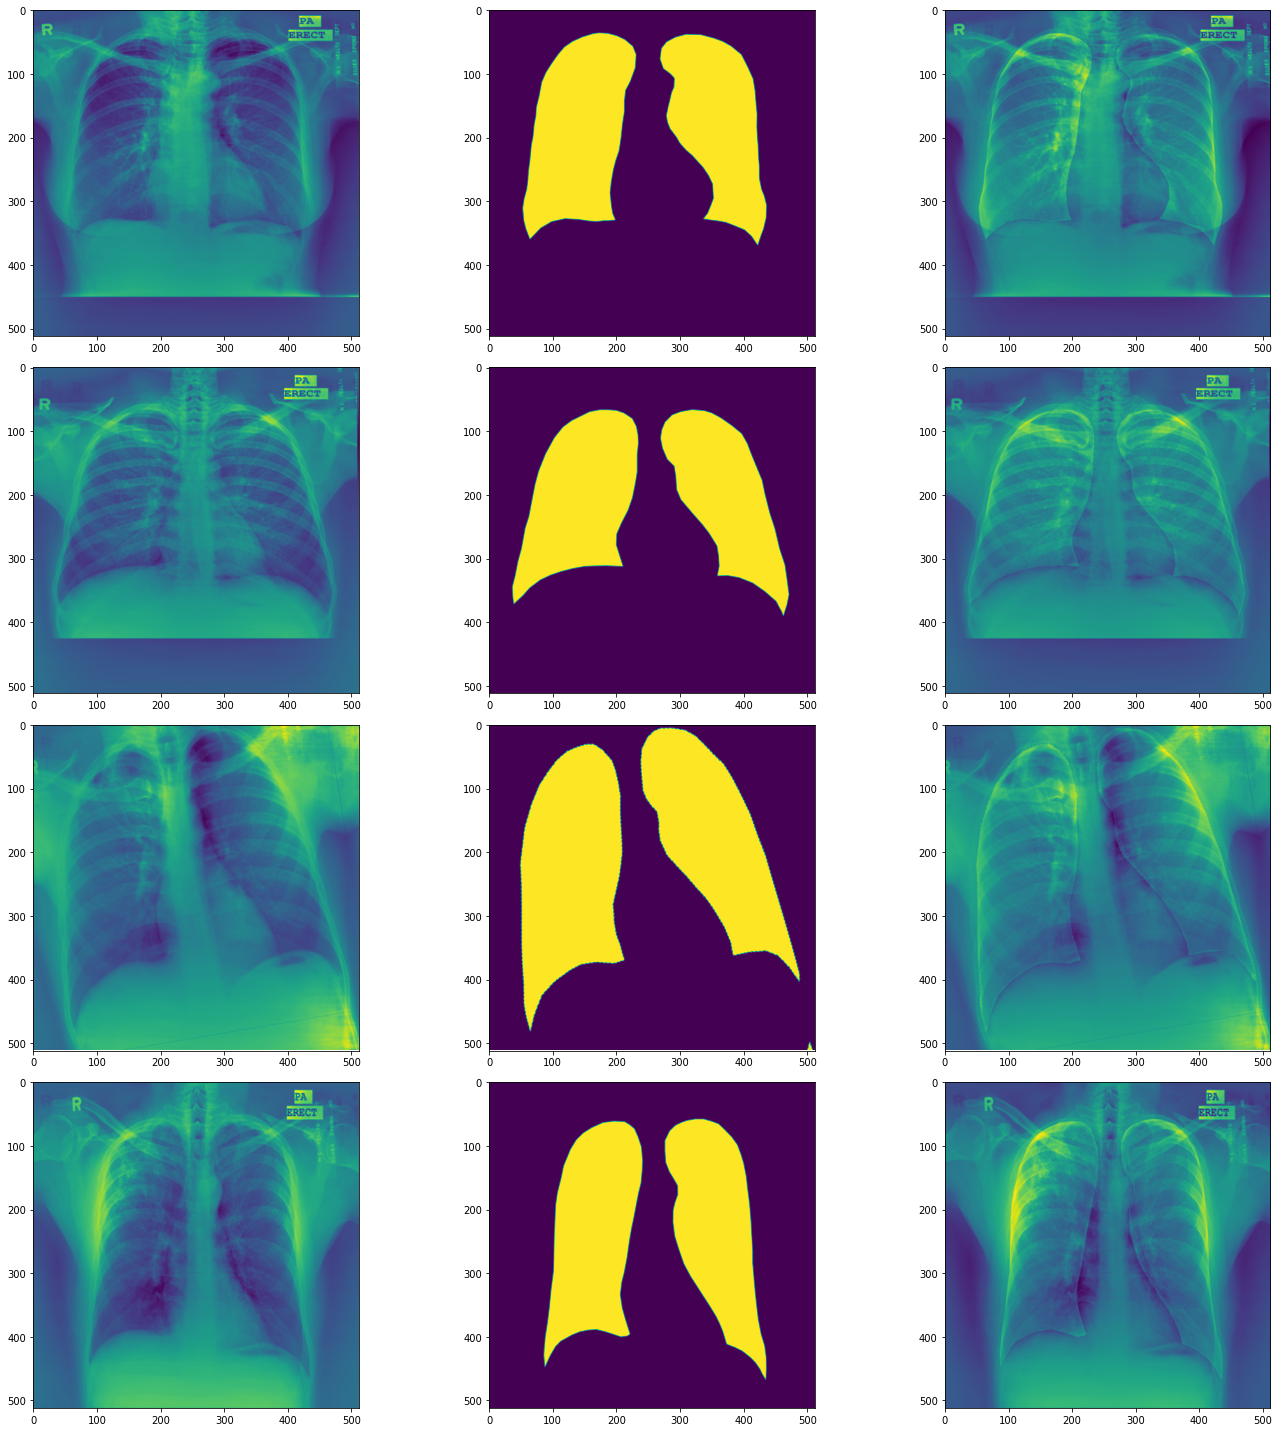

In [20]:
random_plot(loader_images.numpy(), loader_masks.numpy(), 4)